# Cell vertex model visualiation and class development

It would be nice to have some data structures to guide how our versions of cell soap bubble models are created. Let's take a shot at developing some naieve ones.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Each cell is surrounded by $n$ nodes, each node is connected to $m$ other nodes via edges. Each edge has two nodes, two cells, and a radius of curvature. While the edges don't really have a direction, we'll represent them as always going from node $A$ to node $B$ with the radius of curvature being positive if projecting into the right-hand cell if we draw $A$ directly below $B$. 

In [2]:
class node:
    def __init__(self, loc, cells=[], edges=[]):
        """loc is the (x,y) location of the node"""
        self.loc = loc
        self.cells = cells
        self.edges = edges
    
    @property
    def x(self):
        return self.loc[0]
    
    @property
    def y(self):
        return self.loc[1]
    
    def add_cell(self, cell):
        if cell not in self.cells:
            self.cells.append(cell)
    
    def del_cell(self, cell):
        self.cells.remove(cell)
    
    def plot(self, ax):
        ax.plot(self.loc[0], self.loc[1], ".")
        
class edge:
    def __init__(self, node_a, node_b, radius=None):
        self.node_a = node_a
        node_a.edges.append(self)
        self.node_b = node_b
        node_b.edges.append(self)
        self.radius = radius
        
    @property
    def straight_length(self):
        """The distance from node A to node B"""
        return np.linalg.norm(np.subtract(self.node_a.loc, self.node_b.loc))
    
    @staticmethod
    def arc_translation(point1, point2, radius):
        """Get arc center and angles from endpoints and radius

        We want to be able to plot circular arcs on matplotlib axes. 
        Matplotlib only supports plotting such by giving the center, 
        starting angle, and stopping angle for such. But we want to 
        plot using two points on the circle and the radius. 
        
        For explanation, check out https://tinyurl.com/ya7wxoax
        """ 
        x1, y1 = point1
        x2, y2 = point2
        x0, y0 = 0.5*np.subtract(point2, point1)+point1 # midpoint
        a = 0.5*np.linalg.norm(np.subtract(point2, point1)) # dist to midpoint
        assert a<radius, "Impossible arc asked for, radius too small"
        b = np.sqrt(radius**2-a**2) # midpoint to circle center
        xc = x0 + (b*(y0-y1))/a # location of circle center
        yc = y0 - (b*(x0-x1))/a
        theta1 = np.rad2deg(np.arctan2(y2-yc, x2-xc)) # starting angle
        theta2 = np.rad2deg(np.arctan2(y1-yc, x1-xc)) # stopping angle
        return (xc, yc), theta1, theta2
    
    def plot(self, ax, **kwargs):
        a, b = self.node_a, self.node_b
        if self.radius is not None:
            center, th1, th2 = self.arc_translation(a.loc, b.loc, self.radius)
            patch = matplotlib.patches.Arc(center, 2*self.radius, 2*self.radius, 
                                           0, th1, th2, **kwargs)
            ax.add_patch(patch)
        else:
            ax.plot([a.x, b.x], [a.y, b.y], **kwargs)
    
class cell:
    def __init__(self, nodes, edges):
        """
        Parameters
        ----------
        nodes: list of nodes
            Nodes that make up vertices of the cell
        edges: list of edges
            Directed edges that compose the cell
        """
        [node.add_cell(self) for node in nodes]
        self.nodes = nodes
        self.edges = edges
    
    def plot(self, ax):
        """Plot the cell on a given axis"""
        [e.plot(ax) for e in self.edges]
        [n.plot(ax) for n in self.nodes]

To demonstrate how this works, let's try and recreate the following diagram that I've hand drawn. 

![cell diagram](./cell_vertex_graph.png)

As above, the nodes are represented as $n_i$ and the edges as $m_{ij}$ with the right-hand-positive directionality of the radii of curvature. Cells are $c_k$. 

In [3]:
# Node xy locations taken from image, radii are 
# pretty random guesses with some intentionally left out
nodes = [node((250, 290)), #n_a, loc0
         node((343, 424)), #n_b, loc1
         node((520, 249)), #n_c, loc2
         node((321, 108)), #n_d, loc3
         node(( 92,  34)), #n_e, loc4
         node(( 42, 246)), #n_f, loc5
         node(( 83, 446))] #n_g, loc6

edges = [edge(nodes[1], nodes[0],  200), #m_ba, loc0
         edge(nodes[2], nodes[1], None), #m_cb, loc1
         edge(nodes[2], nodes[3],  200), #m_cd, loc2
         edge(nodes[0], nodes[3],  300), #m_ad, loc3
         edge(nodes[5], nodes[0],  900), #m_fa, loc4
         edge(nodes[5], nodes[4], None), #m_fe, loc5
         edge(nodes[3], nodes[4],  300), #m_de, loc6
         edge(nodes[5], nodes[6], 1000), #m_fg, loc7
         edge(nodes[6], nodes[1], 1000)] #m_gb, loc8

## Create list of cell nodes and edges
# Normally I'd do this in the function call but will break out
# here for clarity

cell_a_nodes = [nodes[0], #n_a
                nodes[1], #n_b
                nodes[6], #n_g
                nodes[5]] #n_f
cell_a_edges = [edges[0], #m_ba
                edges[8], #m_gb
                edges[7], #m_fg
                edges[4]] #m_fa

cell_b_nodes = [nodes[0], #n_a
                nodes[3], #n_d
                nodes[2], #n_c
                nodes[1]] #n_b
cell_b_edges = [edges[3], #m_ad
                edges[2], #m_cd
                edges[1], #m_cb
                edges[0]] #m_ba
                
cell_c_nodes = [nodes[4], #n_e
                nodes[3], #n_d
                nodes[0], #n_a
                nodes[5]] #n_f
cell_c_edges = [edges[6], #m_de
                edges[3], #m_ad
                edges[4], #m_fa
                edges[5]] #m_fe

# Create cells
cells = [cell(cell_a_nodes, cell_a_edges),
         cell(cell_b_nodes, cell_b_edges), 
         cell(cell_c_nodes, cell_c_edges)]

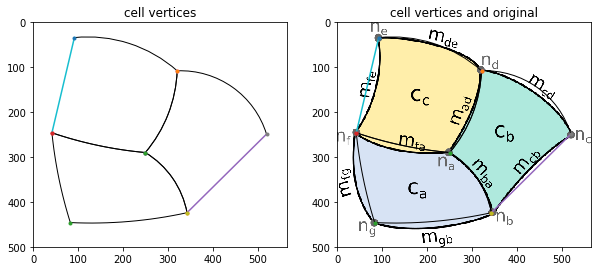

In [4]:
fig, axes = plt.subplots(1,2,figsize=(10,6))

## By itself
[cell.plot(axes[0]) for cell in cells];
axes[0].set_title("cell vertices")

## With original image
img = matplotlib.image.imread('cell_vertex_graph.png')
axes[1].imshow(img)
[cell.plot(axes[1]) for cell in cells]
axes[1].set_title("cell vertices and original")

[a.set(xlim=(0,img.shape[1]), ylim=(img.shape[0], 0), aspect=1) for a in axes]
plt.show()

That looks like the plotting is working as expected. I'm going to call this good for a start. 